In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
import os
IMG_SHAPE = (512, 512)
N_CHANNELS = 1
INPUT_SHAPE = (256, 256, 1)
N_CLASSES = 1
BATCH_SIZE = 20
DATASET_PATH = f"{os.path.expanduser('~')}/Datasets/SEGTHOR_EXTRACTED"
from model import EfficientUnet

model = EfficientUnet(input_shape = INPUT_SHAPE)
model.load_weights(f"records/{model.name}/best/checkpoint/{model.name}")

import segmentation_models as sm
dice_score = sm.metrics.FScore(threshold=0.5)
precision_score = tf.keras.metrics.Precision(thresholds=0.5)
recall_score = tf.keras.metrics.Recall(thresholds=0.5)
iou_score = sm.metrics.IOUScore(threshold=0.5)

2023-10-24 19:33:58.194630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 19:33:58.890961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-10-24 19:33:58.891014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2023-10-24 19:33:58.891020: W tensorflow/compiler/tf2tensorrt/utils/py_uti

Segmentation Models: using `keras` framework.


2023-10-24 19:33:59.902582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 19:33:59.903083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 19:33:59.903542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 19:33:59.903939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

# Get Training History

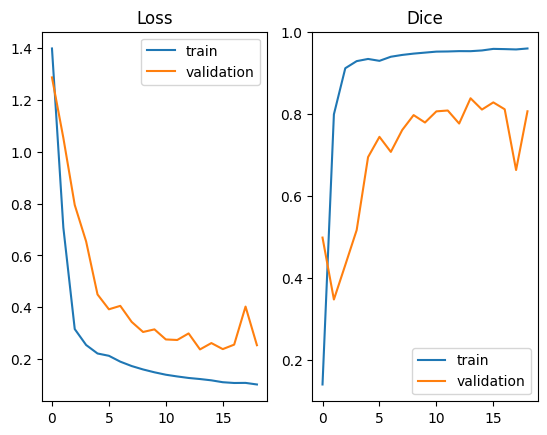

In [2]:
import pickle
import matplotlib.pyplot as plt

with open(f"records/{model.name}/best/history", "rb") as f:
    history = pickle.load(f)

train_loss = history["loss"]
val_loss = history["val_loss"]

train_f1 = history["f1-score"]
val_f1 = history["val_f1-score"]

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train", "validation"])

plt.subplot(1, 2, 2)
plt.title("Dice")
plt.plot(train_f1)
plt.plot(val_f1)
plt.legend(["train", "validation"])

# Metrics Without Post Processing

In [3]:
import numpy as np
from glob import glob
import tfpreprocessing as tfp
from segthor_generators import PatientSliceGenerator
import preprocessing as pre

preprocessing_pipeline = tfp.Pipeline([
    pre.resize((256, 256)),
    pre.windowing(-89, 66),
    pre.norm(),
    pre.expand_dims(),
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/val/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))
    
for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

2023-10-24 19:34:07.016389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


dice : 0.6652632355690002
precision : 0.5288625955581665
recall : 0.8949486017227173
iou_score : 0.5075191259384155


# Metrics With Post Processing

In [4]:
import numpy as np
import tfpreprocessing as tfp
import postprocessing
from glob import glob
from segthor_generators import PatientSliceGenerator

preprocessing_pipeline = tfp.Pipeline([
    pre.resize((256, 256)),
    pre.windowing(-89, 66),
    pre.norm(),
    pre.expand_dims(),
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/val/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)
    volume_pred = postprocessing.biggest_3D_object(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))

for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

dice : 0.7521740198135376
precision : 0.568382203578949
recall : 0.9029502868652344
iou_score : 0.6079491972923279


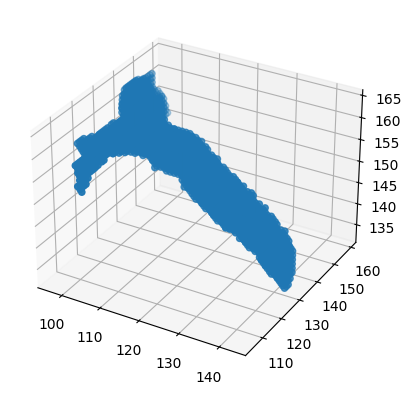

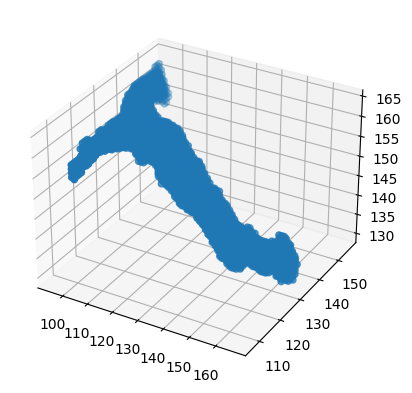

In [5]:
def plot_volume(volume): # (x, y, z) with values 0 or 1 (binary segmentation mask/volume)
    import matplotlib.pyplot as plt    

    ix = np.argwhere(volume != 0)
    x = ix[:, 0]
    y = ix[:, 1]
    z = ix[:, 2]
    
    # Do the plotting in a single call.
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    ax.scatter(x, y, z)
    plt.show()
plot_volume(volume_true)
plot_volume(volume_pred)

{'lower_bound': -83, 'upper_bound': 72, 'learning_rate': 0.0005116242755399432}
